# Introduction
In this project, I will do a sentiment analysis with Random Forest Classifier for a supervised dataset containing some tweets and detailed information about regarding tweets. Data can be found [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Table of contents
- [Reading and cleaning the data](#Reading-and-cleaning-the-data)
- [Feature engineering](#Feature-engineering)
- [Preprocessing](#Preprocessing)
- [Model evaluation](#Model-evaluation)
- [Conclusion](#Conclusion)

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/datht/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/datht/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Reading and cleaning the data
I'll start with importing necessary libraries and modules and then read the csv file into pandas dataframe. Then, I will clean the dataset to make it ready for the preprocessing step.

In [2]:
# Import libraries and modules
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
# total_data = pd.read_csv("/home/datht/sentiment/data/combine/all.csv", encoding="ISO-8859-1") = pd.read_csv("/home/datht/sentiment/data/combine/kfolds_0/train.csv", encoding="ISO-8859-1")
train_df = pd.read_csv("/home/datht/sentiment/data/combine/kfolds_0/train.csv", 
                       encoding="ISO-8859-1")
val_df = pd.read_csv("/home/datht/sentiment/data/combine/kfolds_0/test.csv", 
                     encoding="ISO-8859-1")
all_df = []
for values in train_df.values:
    values = values.tolist()
    values.append('train')
    all_df.append(values)
for values in val_df.values:
    values = values.tolist()
    values.append('test')
    all_df.append(values)
print(all_df[0])
columns = train_df.columns
print(columns.tolist())
data = pd.DataFrame(all_df, columns=train_df.columns.tolist() + ['split'])
data

[567737449938685952, 'negative', "@SouthwestAir no flights out of #nashville today? Are you kidding me?!?! Why are other airlines flying and you're not?! So frustrated!!", 'train']
['tweet_id', 'label', 'text']


,tweet_id,label,text,split
0,567737449938685952,negative,@SouthwestAir no flights out of #nashville tod...,train
1,567737317432258560,neutral,@SouthwestAir I am but it says yall are sold o...,train
2,567736870365171713,negative,@SouthwestAir I'm trying to change a family va...,train
3,567736166787850240,neutral,@SouthwestAir F5R3ZZ,train
4,567735766416392194,positive,.@SouthwestAir you've got a mess here at DTW b...,train
...,...,...,...,...
33372,567737962541375490,neutral,@SouthwestAir landing early morning @BWI_Airpo...,test
33373,567737653118779392,positive,@SouthwestAir and thanks!,test
33374,567737625637687296,neutral,@SouthwestAir sure. Fhk2te. Am scheduled to le...,test
33375,567737617031380992,positive,@SouthwestAir its all good. flight eventually ...,test


Even though there are many information in this dataset, I'll be using only two columns which are 'airline_sentiment' and 'text'. So, let's start with creating a new dataframe for that information only.

In [7]:
# Create a new dataframe for only two columns
tweets = data.loc[:,['label','text', 'split']]
tweets.head()

,label,text,split
0,negative,@SouthwestAir no flights out of #nashville tod...,train
1,neutral,@SouthwestAir I am but it says yall are sold o...,train
2,negative,@SouthwestAir I'm trying to change a family va...,train
3,neutral,@SouthwestAir F5R3ZZ,train
4,positive,.@SouthwestAir you've got a mess here at DTW b...,train


Since the rows in 'text' column contains many words and punctuations that I will not need for analysis, I'll clean those first. In this step, I'll remove all punctuations, mentions in tweets (the words starting with @), convert everything to lower case, tokenize and lemmatize the words and remove the stopwords.

In [8]:
import re
import string

# Stopwords in English language
stopword = nltk.corpus.stopwords.words('english')

# Lemmatizer
wn = nltk.WordNetLemmatizer()

# Function to clean and tokenize the data
def clean_tokenize_text(text):
    # Remove mentions starting with @
    text = re.sub('@\w+\s', '', text)
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    text = text.lower()
    
    # Tokenize the text
    tokens = re.split('\W+', text)
    
    # Remove stopwords
    text = [word for word in tokens if word not in stopword]
    
    # Lemmatize the words
    text = [wn.lemmatize(word) for word in text]
    
    # Return text
    return text


# Apply the function to text column
tweets['text'] = tweets['text'].apply(lambda x: clean_tokenize_text(x))

# Display first five rows
tweets.head()

,label,text,split
0,negative,"[flight, nashville, today, kidding, airline, f...",train
1,neutral,"[say, yall, sold, amp, coworkers, would, need,...",train
2,negative,"[im, trying, change, family, vacation, due, me...",train
3,neutral,[f5r3zz],train
4,positive,"[youve, got, mess, dtw, staff, great]",train



## Feature engineering

In this step, I want to see if creating a new feature may have any impact on model's performance in next steps. As a new feature, text length may be added to see if negative, neutral or positive tweets have much difference in text length. For this purpose, I will use the character count in tweets in the uncleaned dataset. It includes mentions as well, but since it's a dataset consists of tweets which were written to airlines, almost all of them should include mentions in them. Even if they don't, it's not important in this step.

In [10]:
# Create a new column for character count in a tweet
tweets['text_len'] = data['text'].apply(lambda x: len(x) - x.count(' '))

# Rename the columns
tweets.columns=['label','body', 'split', 'text_len']

tweets.head()

,label,body,split,text_len
0,negative,"[flight, nashville, today, kidding, airline, f...",train,115
1,neutral,"[say, yall, sold, amp, coworkers, would, need,...",train,89
2,negative,"[im, trying, change, family, vacation, due, me...",train,113
3,neutral,[f5r3zz],train,19
4,positive,"[youve, got, mess, dtw, staff, great]",train,62


Let's see the density distribution of character counts in every tweet in our dataset.

/home/datht/11785-Project/.env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/datht/11785-Project/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == "__main__":
/home/datht/11785-Project/.env/lib

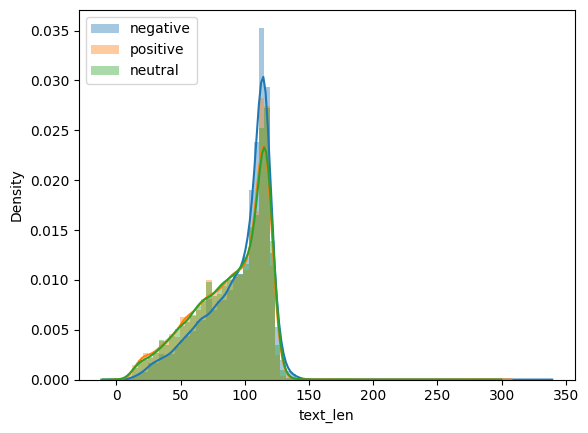

In [11]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Create a density plot for character counts for each label
bins = np.linspace(0,140,35)
sns.distplot(tweets[tweets['label']=='negative']['text_len'], bins, label='negative')
sns.distplot(tweets[tweets['label']=='positive']['text_len'], bins, label='positive')
sns.distplot(tweets[tweets['label']=='neutral']['text_len'], bins, label='neutral')
plt.legend(loc='upper left')
plt.show()

It seems like while the distribution character counts in neutral and positive tweets almost the same, negative tweets have more characters then the others. It might be because people tend to write more characters when they are angry or upset or complaining about something to explain the situation.

## Preprocessing
Now, I'll split train and test set and vectorize them with TF-IDF Vectorizer. But first, I'll create the dataset again to be used in the model because this time I will not clean and tokenize the dataset before splitting text and train sets since TF-IDF Vectorizer does it already with the function passed in.

### Train/Test set split

In [20]:

train_inds = [i for i, split in enumerate(total_data['split'].values) if split == 'train']
test_inds = [i for i, split in enumerate(total_data['split'].values) if split == 'test']

# X_train = data.values[train_inds]
# X_test = data.values[test_inds]
# y_train = data[].values[train_inds]
# y_test = data[sentiment].values[test_inds]


# Create a new dataframe for 'airline_sentiment' and 'text' columns
# data = data.loc[:,['label','text']]

# Rename the columns
# data.columns = ['label', 'body']

# Create a column for character counts in each tweet except for white spaces
data['text_len'] = data['body'].apply(lambda x: len(x) - x.count(" "))

# Import module
from sklearn.model_selection import train_test_split


X_train = data[['body','text_len']].iloc[train_inds]
X_test = data[['body', 'text_len']].iloc[test_inds]

y_train = data[['label']].iloc[train_inds]
y_test = data[['label']].iloc[test_inds]

# Split train and test sets
# X_train, X_test, y_train, y_test = train_test_split(data[['body', 'text_len']], data['label'], test_size=0.2)

### Vectorizing the text
After creating a TF-IDF Vectorizer, I will only fit the train set because I don't want it to know the words in test set. Giving all the data to the model to fit may impact test set accuracy in later steps.

In [21]:
# Create a TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_tokenize_text)

# Fit the train set
tfidf_vect_fit = tfidf_vect.fit(X_train['body'])

# Transform train and test sets
tfidf_train = tfidf_vect_fit.transform(X_train['body'])
tfidf_test = tfidf_vect_fit.transform(X_test['body'])

# Create new dataframe for train and test sets including 'text_len' column
X_train_vect = pd.concat([X_train['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)

X_test_vect = pd.concat([X_test['text_len'].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

# Display first 5 rows of vectorized train set
X_train_vect.head()


,text_len,0,1,2,3,4,5,6,7,8,...,36182,36183,36184,36185,36186,36187,36188,36189,36190,36191
0,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we have a tf-idf vectorized dataframe for every word in the dataset. Also, I've added text_len feature to it. Let's see some of the feature names that appear in our vectorized dataset in the following code cell.

In [22]:
# Get the first 10 feature names in whole dataset
print(tfidf_vect.get_feature_names()[0:10])

['', '0', '00', '0000', '002013', '0030', '003045', '006', '007', '01']


/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Model evaluation

Let's try Grid Search for Random Forest Classifier to find the most ideal hyperparameters for the model.

### Grid Search with Random Forest Classifier

In [23]:
# Import random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Import cross validation score evaluation
from sklearn.model_selection import cross_val_score

# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [24]:
# Define parameters
param = {
    'n_estimators': [10, 50, 100], 
    'max_depth': [10, 20, 30, None],
    }

# Create a model
clf = GridSearchCV(RandomForestClassifier(), param,cv=5, n_jobs=None)

# Fit the vectorized train set
rf_model = clf.fit(X_train_vect, y_train)

# Create a dataframe for the cross validation results
pd.DataFrame(rf_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]


/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature n

KeyboardInterrupt: 

So, it seems like random forest classifier with n_estimators=100 or n_estimators=50 and max_depth=None parameters would give us the best result with 0.75 mean test score for this dataset. Let's finalize our model with the given hyperparameters.

### Finalizing the model
I will set the hyperparameters to the ones that grid search gave the best result with and calculate some evaluation metrics to see the model's performance.

In [25]:
# Create a model with defined parameters
rf_class = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1)

# Fit the vectorized train set to the model
rf_model = rf_class.fit(X_train_vect, y_train)

/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/datht/11785-Project/.env/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [26]:
# Display feature importances with feature names
sorted(zip(rf_model.feature_importances_, X_train_vect.columns), reverse=True)[0:10]

[(0.018068094283478383, 'text_len'),
 (0.013838680245448265, 10566),
 (0.006492524430131559, 32616),
 (0.006237841184159983, 33173),
 (0.005617362131297045, 13029),
 (0.005596931988058713, 33728),
 (0.005409782708084032, 32608),
 (0.005401850831392444, 7561),
 (0.0048333365969352796, 22961),
 (0.004666707721050581, 11934)]

In [33]:
y_test

,label
26701,neutral
26702,positive
26703,neutral
26704,negative
26705,negative
...,...
33372,neutral
33373,positive
33374,neutral
33375,positive


In [34]:
y_pred = rf_model.predict(X_test_vect)

result1 = y_pred
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
acc = accuracy_score(y_test, result1)
print(f'Accuracy: micro: {acc:.3f}')

p_micro = precision_score(y_test, result1, average='micro')
p_macro = precision_score(y_test, result1, average='macro')
print(f'Precision: micro-macro: {p_micro:.3f}-{p_macro:.3f}')

r_micro = recall_score(y_test, result1, average='micro')
r_macro = recall_score(y_test, result1, average='macro')
print(f'Recall: micro-macro: {r_micro:.3f}-{r_macro:.3f}')

f1_micro = f1_score(y_test, result1, average='micro')
f1_macro = f1_score(y_test, result1, average='macro')
print(f'F1: micro-macro: {f1_micro:.3f}-{f1_macro:.3f}')

print(
    classification_report(
        y_test, result1, target_names=["negative", "neutral", "positive"]
    )
)

n_true_pos = 0
n_true_neu = 0
n_true_neg = 0
for p, l in zip(result1, y_test.values):
    if p == l and l == 'positive':
        n_true_pos += 1
    elif p == l and l == 'neutral':
        n_true_neu += 1
    elif p == l and l == 'negative':
        n_true_neg += 1
print(n_true_pos, n_true_neu, n_true_neg)

/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Accuracy: micro: 0.717
Precision: micro-macro: 0.717-0.673
Recall: micro-macro: 0.717-0.628
F1: micro-macro: 0.717-0.646
              precision    recall  f1-score   support

    negative       0.77      0.86      0.81      3956
     neutral       0.55      0.48      0.51      1515
    positive       0.70      0.55      0.61      1205

    accuracy                           0.72      6676
   macro avg       0.67      0.63      0.65      6676
weighted avg       0.71      0.72      0.71      6676

658 721 3408


We can see that the feature 'text_len' that gives the character count for each tweet has the best impact on our model.

In [27]:
from sklearn.metrics import precision_recall_fscore_support as score

# Predict the vectorized test set
y_pred = rf_model.predict(X_test_vect)

# Get scores
precision, recall, fscore, support = score(y_test, y_pred, average='weighted')

/home/datht/11785-Project/.env/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [28]:
# Save the model
import joblib
joblib.dump(rf_model, 'rf_model.pkl')

['rf_model.pkl']

In [29]:
# Print the scores
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

/home/datht/11785-Project/.env/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


ValueError: Unable to coerce to Series, length must be 1: given 6676

In [ ]:
from sklearn.metrics import classification_report

# Create a classification report
print(classification_report(y_test, y_pred))

## Conclusion

In conclusion, the model is the best in predicting 'negative' tweets correctly with 0.77 precision, 0.95 recall and 0.85 f-1 scores. And it's not as good in predicting the other classes. But overall, it has 76.0% accuracy rate in predicting which class a tweet belongs to. 